# Evaluation on Kang Data

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["SCIPY_ARRAY_API"] = "1"
print(os.environ.get("SCIPY_ARRAY_API"))


# Do not show FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import os
import pandas as pd
import anndata as ad
import numpy as np
import benchmark as bm
import plotnine as p9
from mofaflex import MOFAFLEX
from mofaflex import FeatureSets as fs
from scarches.models import EXPIMAP
import pickle
import plotting
from plotting import discrete_scale_fill, discrete_scale_color

%matplotlib
%matplotlib inline

# Settings
device = "cuda:1"   
seed = 1
rng = np.random.default_rng(seed)

1


/data/m015k/micromamba/envs/prismo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


Spectra GPU support is still under development. Raise any issues on github 
 
 Changes from v1: 
 (1) GPU support [see tutorial] 
 (2) minibatching for local parameters and data 
 Note that minibatching may affect optimization results 
 Code will eventually be merged into spectra.py
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [ ]:
# Test Parameters
FPR = 0.3
database = "RH"
version = "v1-3000"

LOAD_EXPIMAP = True
LOAD_SPECTRA = True
LOAD_MOFAFLEX = True

## Load data and Reactome pathways

### Preprocessing

In [3]:
adata, true_mask, noisy_mask, terms, true_mask_copy = bm.get_data(
    FPR, FPR, database=database, version=version, seed=seed, rng=rng
)
data_dict = bm.preprocess(adata)

INFO:mofaflex._core.feature_sets:Found 16 pairs to merge.
INFO:mofaflex._core.feature_sets:Found 3 pairs to merge.
INFO:mofaflex._core.feature_sets:Found 2 pairs to merge.
INFO:mofaflex._core.feature_sets:Found 0 pairs to merge. Stopping...


# Train all Models

In [4]:
model_dict = {}

### Train Expimap

In [5]:
soft_mask = True
recon_loss = "mse"
model_name = f"/data/m015k/mofaflex/benchmark/models_kang/expimap_{database}_{FPR}_{version}_{seed}"

if LOAD_EXPIMAP & os.path.exists(model_name):
    print("Loading model")
    adata = ad.AnnData(data_dict["expimap"])
    adata.obs["cond"] = "cond"
    adata.varm["I"] = noisy_mask.T
    adata.uns["terms"] = terms
    model_dict["expimap"] = EXPIMAP.load(model_name, adata=adata)
else:
    print("Training model")
    model_dict["expimap"] = bm.train_expimap(
        data_dict["expimap"],
        noisy_mask,
        seed=seed,
        terms=terms,
        recon_loss=recon_loss,
        n_epochs=1000,
        batch_size=1000,
        soft_mask=soft_mask,
        hidden_size_1=512,
        hidden_size_2=256,
    )
    model_dict["expimap"].save(model_name)

Loading model
AnnData object with n_obs × n_vars = 13576 × 3000
    obs: 'cond'
    uns: 'terms'
    varm: 'I'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 512 1
	Hidden Layer 1 in/out: 512 256
	Mean/Var Layer in/out: 256 65
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  65 0 0 1 3000
	with soft mask.
Last Decoder layer: identity


### Train Sepctra

In [6]:
model_name = f"/data/m015k/mofaflex/benchmark/models_kang/spectra_{database}_{FPR}_{version}_{seed}"

if LOAD_SPECTRA & os.path.exists(f"{model_name}.pkl"):
    with open(f"{model_name}.pkl", "rb") as f:
        model_dict["spectra"] = pickle.load(f)
else:
    model_dict["spectra"] = bm.train_spectra(
        data_dict["spectra"], noisy_mask, terms=terms, num_epochs=10000
    )

    # Save the model
    with open(f"{model_name}.pkl", "wb") as f:
        pickle.dump(model_dict["spectra"], f)

### Train PRISMO

In [7]:
for model_name_parmams in [
    f"mofaflex_0.001_200_5000_0.005_2_0.1_{database}_{FPR}_{version}_{seed}",
]:
    for model_name in ["mofaflex", "mofaflex_nmf"]:
        if "nmf" in model_name:
            model_name_parmams = model_name_parmams.replace("mofaflex", "mofaflex_nmf")

        def extract_params_from_string(s: str) -> tuple[str, ...]:
            parts = s.replace("_nmf", "").split("_")[1:7]
            return tuple(parts)

        # Usage
        params = extract_params_from_string(model_name_parmams)
        lr, early_stopper_patience, max_epochs, prior_penalty, n_factors, dense_factor_scale = params

        if LOAD_MOFAFLEX & os.path.exists(f"/data/m015k/mofaflex/benchmark/models_kang/{model_name_parmams}.h5"):
            print(f"Loading Model {model_name_parmams}")
            model_dict[model_name] = MOFAFLEX.load(f"/data/m015k/mofaflex/benchmark/models_kang/{model_name_parmams}.h5")
        else:
            print("Training Model")
            model_dict[model_name] = bm.train_mofaflex(
                data_dict[model_name],
                noisy_mask,
                obs=adata.obs,
                var=adata.var,
                seed=seed,
                terms=terms,
                obs_names=adata.obs_names.copy(),
                var_names=adata.var_names.copy(),
                n_factors=n_factors,
                nmf="nmf" in model_name,
                prior_penalty=prior_penalty,
                max_epochs=max_epochs,
                batch_size=0,
                n_particles=1,
                lr=lr,
                early_stopper_patience=early_stopper_patience,
                device=device,
                true_mask=true_mask,
                init_factors="random",
                init_scale=0.1,
                save_path=f"/data/m015k/mofaflex/benchmark/models_kang/{model_name_parmams}.h5",
                dense_factor_scale=dense_factor_scale,
            )

Loading Model mofaflex_0.001_200_5000_0.005_2_0.1_RH_0.3_v1-3000_1
Loading Model mofaflex_nmf_0.001_200_5000_0.005_2_0.1_RH_0.3_v1-3000_1


In [8]:
model = model_dict["mofaflex"]
model_dict = {
    "expimap": model_dict["expimap"],
    "spectra": model_dict["spectra"],
    "mofaflex": model_dict["mofaflex"],
    "mofaflex_nmf": model_dict["mofaflex_nmf"],
}

### Compute Metrics

In [9]:
df_scores = pd.DataFrame(columns=["model", "score", "metric"])

# AUPRC
top = 200
for model_name, model in model_dict.items():
    scores = bm.get_average_precision(true_mask, model, per_factor=True, top=top)
    prec, rec, f1, _ = bm.get_binary_scores(
        true_mask, model, threshold=None, per_factor=True, top=top, verbose=False
    )
    rmse = bm.get_rmse(model, data_dict[model_name])
    _, wh, tm, nm = bm.get_reconstruction_fraction(
        true_mask, noisy_mask, model, top=200
    )
    non_zero = np.abs(wh) > 0.0
    tp = (tm & nm & non_zero).sum(axis=1).tolist()
    tn = (~tm & ~nm & non_zero).sum(axis=1).tolist()
    fp = (~tm & nm & non_zero).sum(axis=1).tolist()  # FIXME
    fn = (tm & ~nm & non_zero).sum(axis=1).tolist()  # FIXME

    df_scores = pd.concat(
        [
            df_scores,
            pd.DataFrame({"model": model_name, "score": scores, "metric": "aupr"}),
            pd.DataFrame({"model": model_name, "score": prec, "metric": "precision"}),
            pd.DataFrame({"model": model_name, "score": rec, "metric": "recall"}),
            pd.DataFrame({"model": model_name, "score": f1, "metric": "f1"}),
            pd.DataFrame(
                {"model": model_name, "score": rmse, "metric": "rmse"}, index=[0]
            ),
            pd.DataFrame({"model": model_name, "score": tp, "metric": "tp"}),
            pd.DataFrame({"model": model_name, "score": tn, "metric": "tn"}),
            pd.DataFrame({"model": model_name, "score": fp, "metric": "fp"}),
            pd.DataFrame({"model": model_name, "score": fn, "metric": "fn"}),
        ]
    )

# Make model column categorical
df_scores["model"] = pd.Categorical(
    df_scores["model"], categories=["expimap", "spectra", "mofaflex", "mofaflex_nmf"]
)

### For each of the models, plot the l2-norm of all factors

df_plot = pd.DataFrame()
for model_name, model in model_dict.items():
    factor_list =  model_dict["prismo"].factor_names[2:]
    # If any string is longer than 40 characters, abbreviate it
    factor_weights = bm.get_factor_scores(model, data_dict[model_name])
    print(factor_weights.shape)
    
    df = pd.DataFrame({"model": model_name, "factor": factor_list, "l2_norm": np.linalg.norm(factor_weights, axis=0)})
    df["color"] = np.where(df["factor"].str.contains("INTERFER"), "blue", "green")
    df["marker"] = np.where(df["factor"].str.contains("INTERFER"), "x", "o")
    df = df.sort_values("l2_norm", ascending=False)
    df = df.head(20)
    df["factor"] = [f"{f[:50]}..." if len(f) > 50 else f for f in df["factor"]]

    # df_plot = pd.concat([df_plot, df])


    p = (
        p9.ggplot(df, p9.aes(x="factor", y="l2_norm", color="color", fill="color", marker="marker"))
        + p9.geom_point(size=4)
        + p9.theme(figure_size=(10, 10))
        + p9.theme(axis_text_x=p9.element_text(rotation=90))
        # + p9.facet_wrap("~model", scales="free")
        + p9.scale_x_discrete(limits=df.sort_values("l2_norm", ascending=False)["factor"].tolist())
        + p9.scale_color_manual(values={"green": "green", "blue": "blue"})
        + p9.scale_fill_manual(values={"green": "green", "blue": "blue"})
        # Set title
        + p9.ggtitle(f"{model_name.title()} Factor Loading Norms")
        # + p9.facet_wrap("~model", scales="free")
        # Remove legend
        # + p9.theme(legend_position="none")
        # Set y axis label
        + p9.ylab("L2 Norm")
        # Set x axis label
        + p9.xlab("Factor")
    )
    p.show()
    

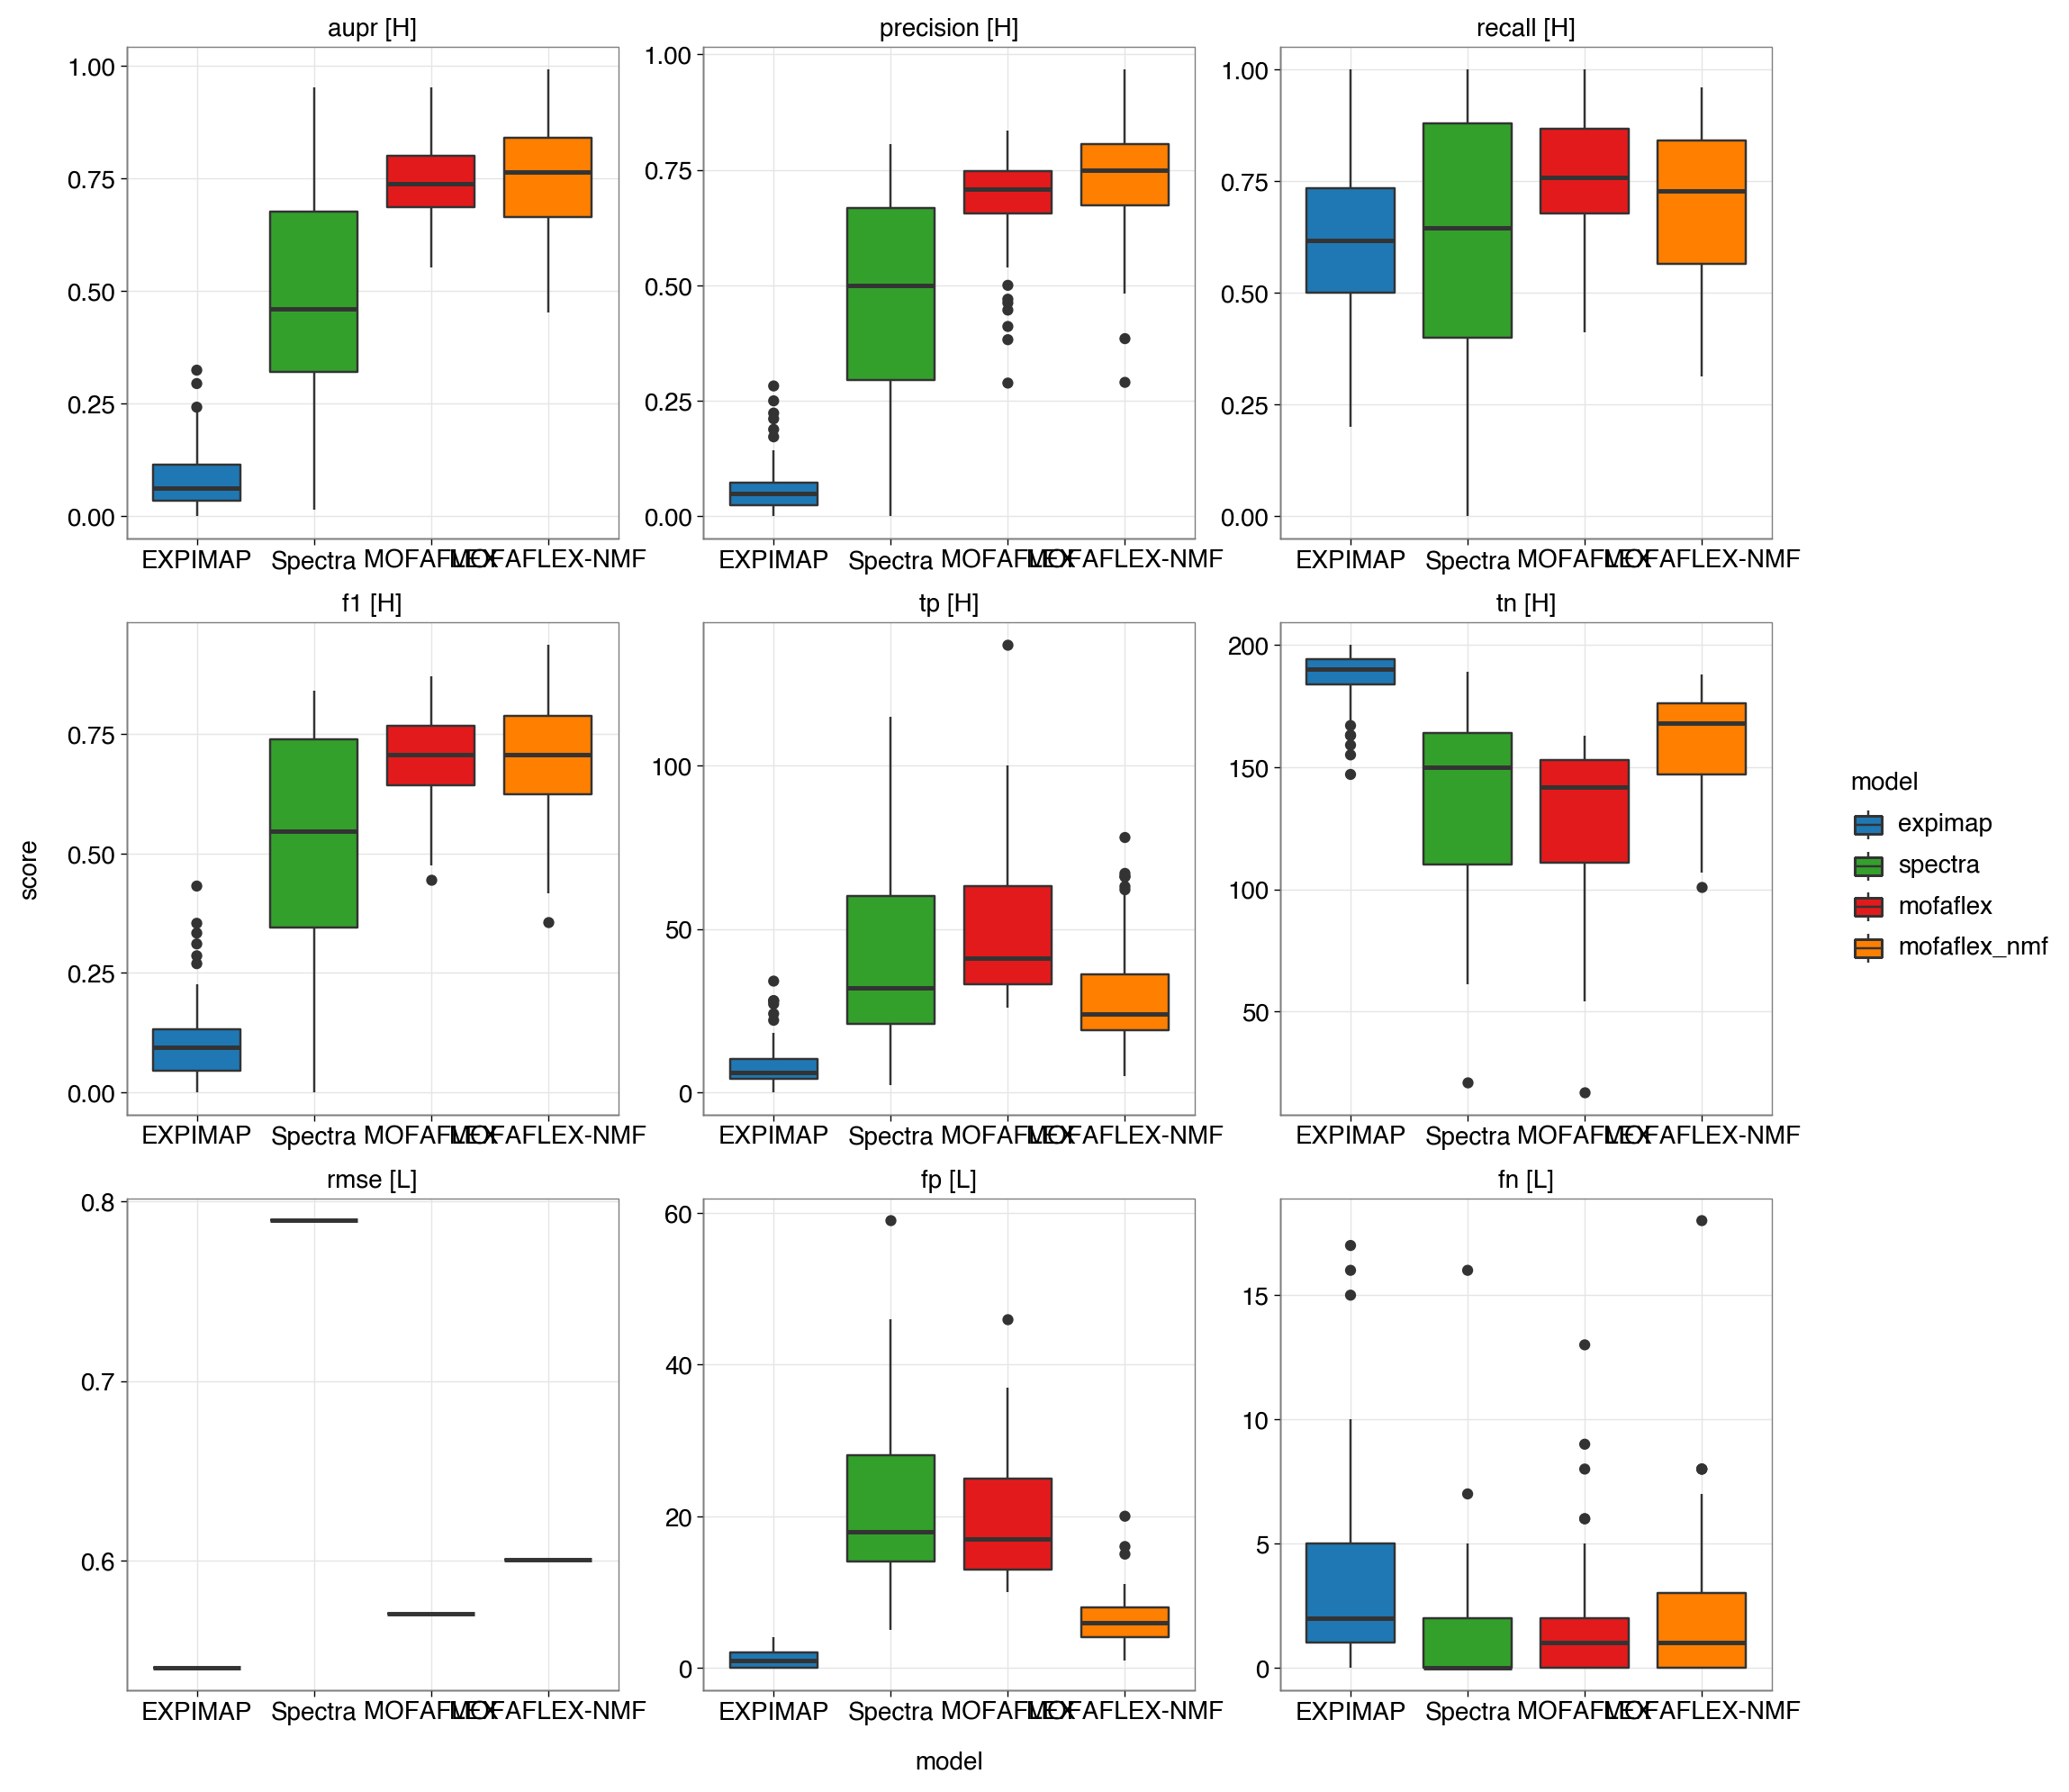

In [10]:
model_labels = ["EXPIMAP", "Spectra", "MOFAFLEX", "MOFAFLEX-NMF"]
df_plot = df_scores.copy()
# Append "↓" to the metric names except for "fn" and "fp" where we add a "↑"
df_plot["metric"] = df_plot.apply(
    lambda x: x["metric"] + (" [L]" if x["metric"] in ["fn", "fp", "rmse"] else " [H]"),
    axis=1,
)
df_plot["metric"] = pd.Categorical(
    df_plot["metric"],
    categories=[
        "aupr [H]",
        "precision [H]",
        "recall [H]",
        "f1 [H]",
        "tp [H]",
        "tn [H]",
        "rmse [L]",
        "fp [L]",
        "fn [L]",
    ],
)

p = (
    p9.ggplot(
        df_plot,
        p9.aes(x="model", y="score", fill="model"),
    )
    + p9.geom_boxplot()
    + p9.theme(axis_text_x=p9.element_text(), figure_size=(14, 10))
    + p9.facet_wrap("~metric", scales="free")
    + discrete_scale_fill
)
if model_labels is not None:
    p = p + p9.scale_x_discrete(labels=model_labels)
p.show()

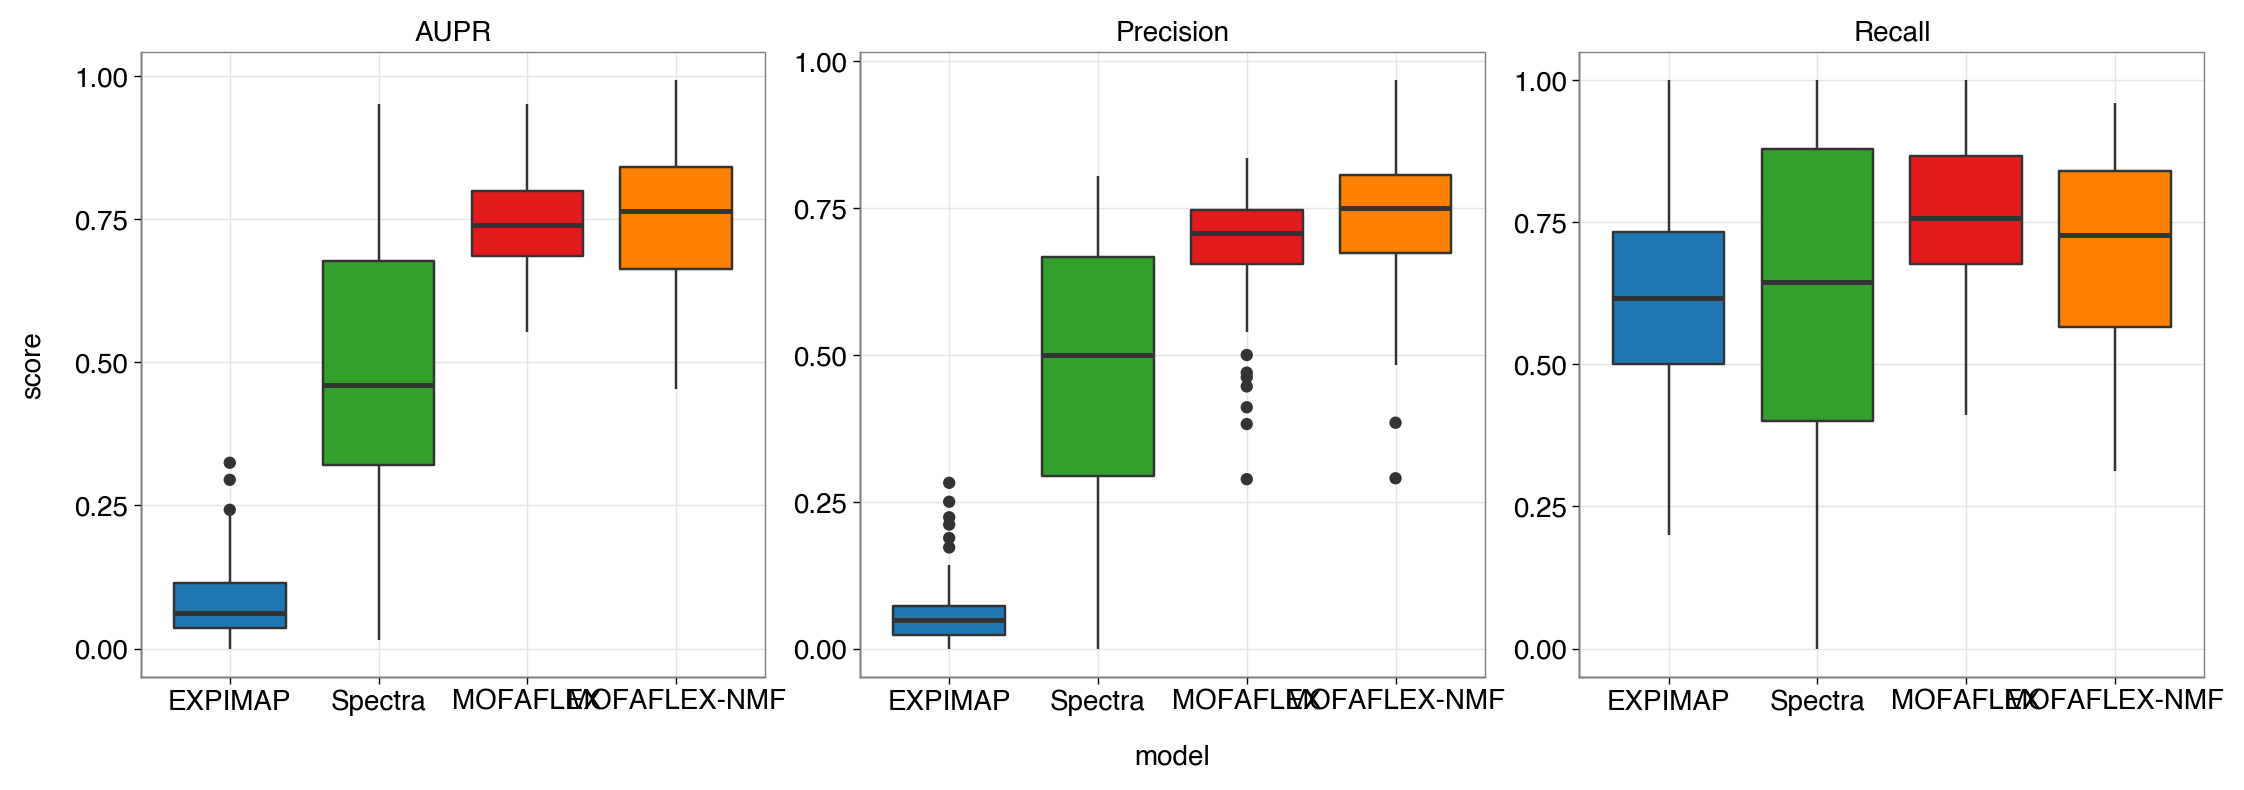

/data/m015k/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 14 x 4 in image.
/data/m015k/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./figures/plot_all.png


In [12]:
model_labels = ["EXPIMAP", "Spectra", "MOFAFLEX", "MOFAFLEX-NMF"]
df_plot = df_scores.copy()
# Append "↓" to the metric names except for "fn" and "fp" where we add a "↑"
df_plot["metric"] = df_plot.apply(
    lambda x: x["metric"] + ("↓" if x["metric"] in ["fn", "fp", "rmse"] else "↑"),
    axis=1,
)
df_plot["metric"] = pd.Categorical(
    df_plot["metric"],
    categories=[
        "aupr↑",
        "precision↑",
        "recall↑",
    ],
)
# Drop all rows with nans
df_plot = df_plot.dropna()
# Rename values
df_plot["metric"] = df_plot["metric"].replace(
    {
        "aupr↑": "AUPR",
        "precision↑": "Precision",
        "recall↑": "Recall",
    }
)

p = (
    p9.ggplot(
        df_plot,
        p9.aes(x="model", y="score", fill="model"),
    )
    + p9.geom_boxplot()
    + p9.theme(axis_text_x=p9.element_text(), figure_size=(14, 4))
    + p9.facet_wrap("~metric", scales="free")
    + discrete_scale_fill
    # Rename legend title
    + p9.labs(fill="Model")
    + p9.theme(legend_position="none")
)
if model_labels is not None:
    p = p + p9.scale_x_discrete(labels=model_labels)
p.show()

# Save figure
p.save(f"./figures/plot_all.png")


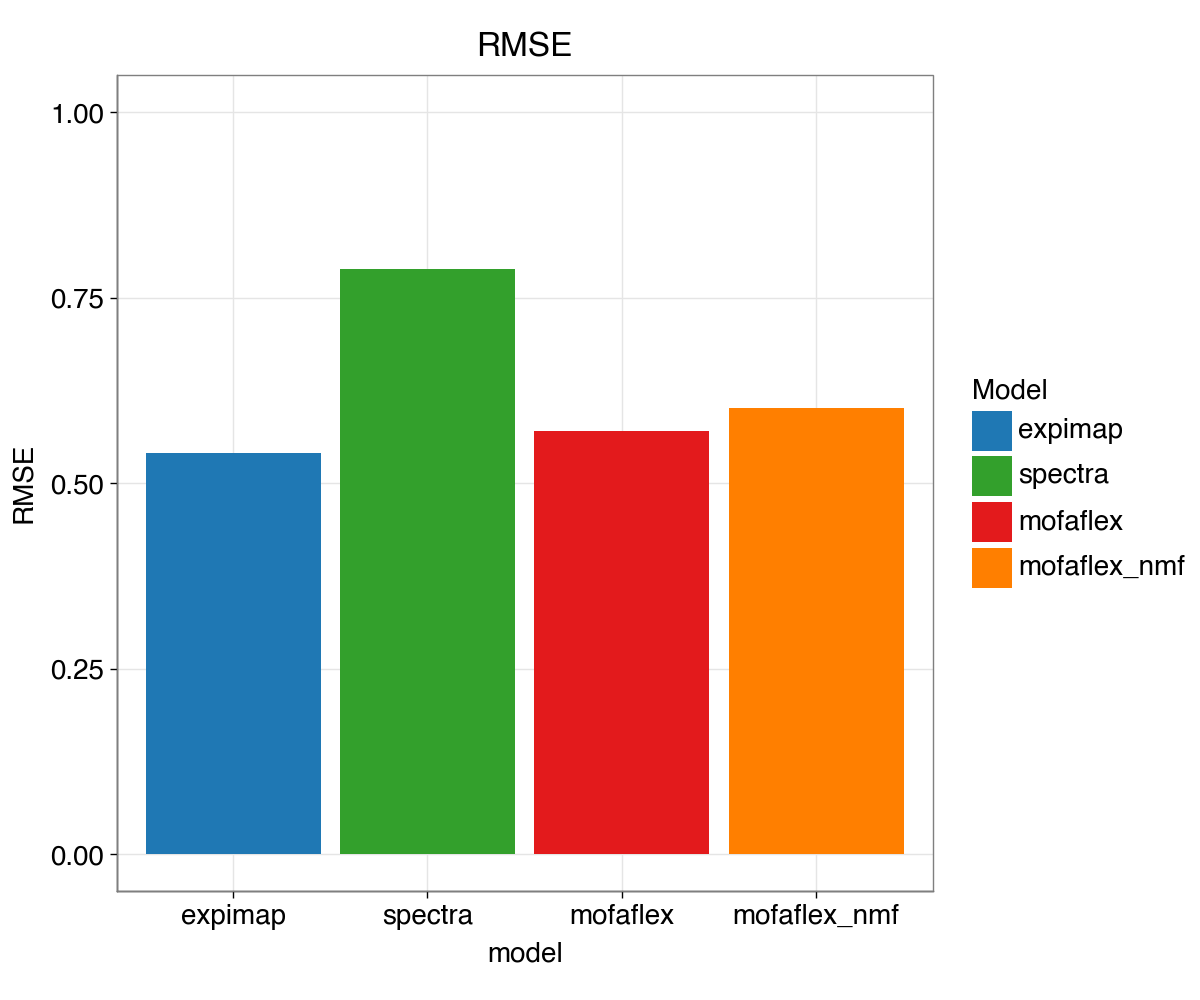

In [13]:
# Make a barplot for the RMSE
df_plot = df_scores[df_scores["metric"] == "rmse"].copy()
df_plot["model"] = pd.Categorical(
    df_plot["model"], categories=["expimap", "spectra", "mofaflex", "mofaflex_nmf"]
)

p = (
    p9.ggplot(
        df_plot,
        p9.aes(x="model", y="score", fill="model"),
    )
    + p9.geom_bar(stat="identity")
    + p9.theme(axis_text_x=p9.element_text(), figure_size=(6, 5))
    + p9.coord_cartesian(ylim=(0, 1))
    + discrete_scale_fill
    + p9.ylab("RMSE")
    + p9.labs(fill="Model")
    # Set title
    + p9.ggtitle("RMSE")
)
p

In [15]:
df_plot["color"] = ["#F8766D", "#00BFC4", "#7CAE00", "#C77CFF"]
df_plot["color"] = pd.Categorical(
    df_plot["color"],
    categories=["#F8766D", "#00BFC4", "#7CAE00", "#C77CFF"],
)
df_plot

,model,score,metric,color
0,expimap,0.540379,rmse,#F8766D
0,spectra,0.789329,rmse,#00BFC4
0,mofaflex,0.570677,rmse,#7CAE00
0,mofaflex_nmf,0.600823,rmse,#C77CFF


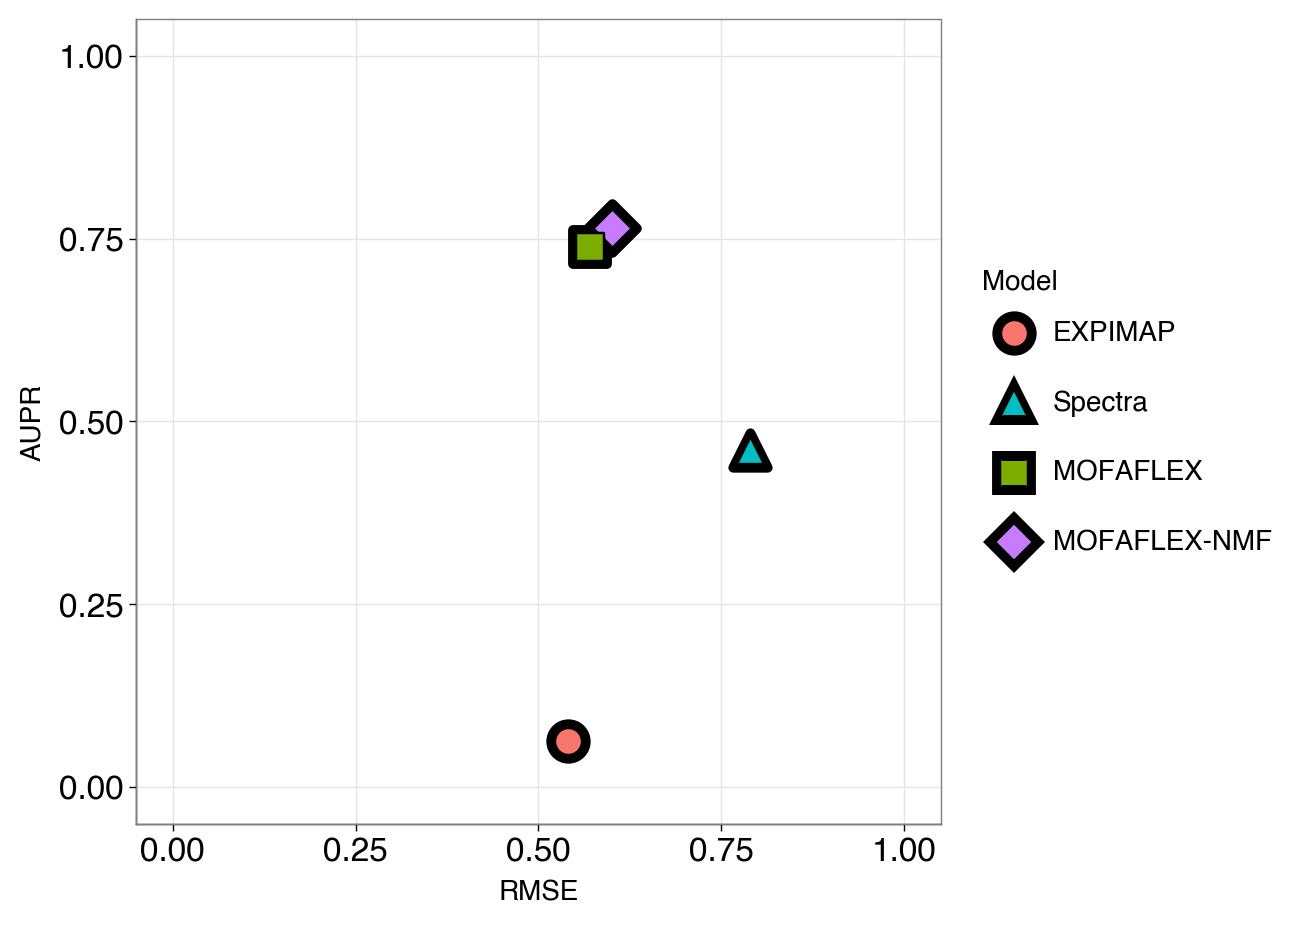

/data/m015k/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/data/m015k/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./figures/plot_rmse_aupr.png


In [16]:
# Make a scatterplot of RMSE vs AUPR from df_scores_grouped
df_scores_grouped = df_scores.groupby(["model", "metric"]).median().reset_index()
df_plot = df_scores_grouped[df_scores_grouped["metric"].isin(["aupr", "rmse"])]
df_plot = df_plot.pivot(index="model", columns="metric", values="score")
df_plot = df_plot.reset_index()
df_plot["model"] = df_plot["model"].replace({"expimap": "EXPIMAP", "spectra": "Spectra", "mofaflex": "MOFAFLEX", "mofaflex_nmf": "MOFAFLEX-NMF"}) 

# Define colors for each model
model_colors = {"EXPIMAP": "#F8766D", "Spectra": "#00BFC4", "MOFAFLEX": "#7CAE00", "MOFAFLEX-NMF": "#C77CFF"}
df_plot["color"] = df_plot["model"].map(model_colors)

p = (
    p9.ggplot(
        df_plot, p9.aes(x="rmse", y="aupr", fill="model", shape="model")
    )
    + p9.geom_point(size=5, stroke=2, color="black")
    + p9.geom_point(size=5)
    + p9.xlim(0.0, 1.0)
    + p9.ylim(0.0, 1.0)
    + p9.theme(legend_position="right")
    + p9.labs(x="RMSE", y="AUPR", fill="Model", shape="Model")  # Unified legend title
    + p9.scale_fill_manual(values=model_colors)  # Map colors to models
    + p9.theme(axis_text_x=p9.element_text(size=12), axis_text_y=p9.element_text(size=12))
)
p.show()

# Save figure
p.save(f"./figures/plot_rmse_aupr.png")
